### Processing the Mold Index on NTA Level

Index calculated through proportion of Moldy and non-Moldy Residential Square foot area per building summarized per NTA. 

#### Author Matthias Fitzky

In [25]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


In [26]:
# MoldClassification=pd.read_csv(r'..\Output\bbl_mold_risk_RF_balanced_pr04_05032023.csv')
MoldClassification=pd.read_csv(r'..\Output\bbl_mold_risk_RF_balanced_pr047_05042023.csv')


In [27]:
MoldClassification

,bbl,actual_mold,predicted_mold,mold_prob
0,3018090016,0.0,0,0.250147
1,3061830033,0.0,0,0.242914
2,3062060022,0.0,0,0.268979
3,3018520037,0.0,1,0.577286
4,3058930008,0.0,1,0.453897
...,...,...,...,...
749378,4011660056,0.0,1,0.413721
749379,3006480027,0.0,0,0.218420
749380,4016860008,0.0,0,0.353632
749381,3020990083,0.0,1,0.548012


In [28]:
#Load CLeaned Pluto Dataset
plutoCleaned=pd.read_csv(r'..\Output\pluto_processed.csv')
plutoCleanedGeo = gpd.GeoDataFrame(plutoCleaned, geometry=gpd.points_from_xy(plutoCleaned.longitude, plutoCleaned.latitude),crs='EPSG:4326')

In [29]:
#NTA Map
NTA=gpd.read_file(r'..\Data\NTA map.geojson')

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


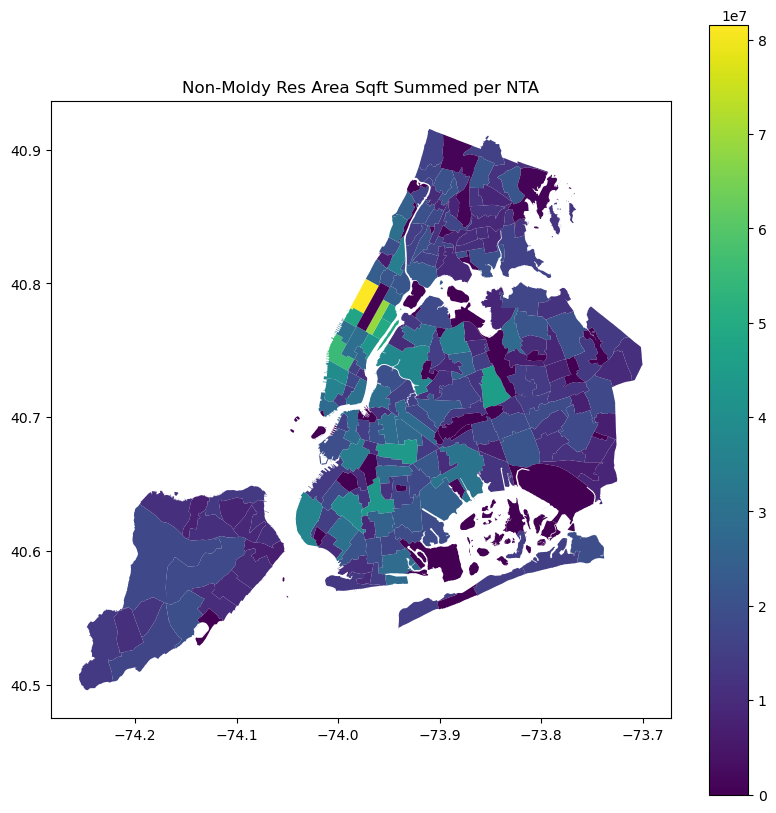

In [30]:
# Spatial join the Pluto centroids with the NTAs to get NTACode for each Pluto Point. Then Sum up resarea from pluto per NTA. THen Merge back with NTA geometry for plotting purposes. 
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
ResAreaperNTA=pluto_ntas.groupby(by='ntacode').agg({'resarea':'sum'})
NTAResArea=gpd.GeoDataFrame(ResAreaperNTA.merge(NTA,on='ntacode'),geometry='geometry')
fig, ax = plt.subplots(figsize=(10,10))
NTAResArea.plot(column='resarea', legend=True, ax=ax, missing_kwds= dict(color = "lightgrey",) )
ax.set_title('Non-Moldy Res Area Sqft Summed per NTA')
plt.show()

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


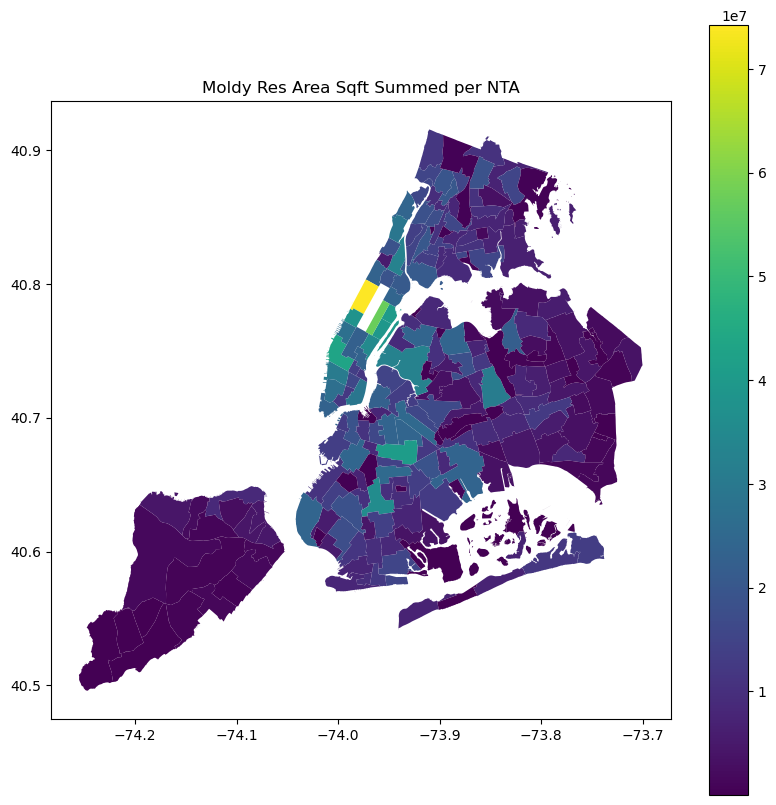

In [31]:
#Same but for Moldy Plutos
PlutoMoldClassification=gpd.GeoDataFrame(MoldClassification.merge(plutoCleanedGeo,on='bbl'),geometry='geometry')
PlutoMoldyBldgs=PlutoMoldClassification.loc[PlutoMoldClassification['predicted_mold']==1]
PlutoMoldyBldgsNTAs = gpd.sjoin(PlutoMoldyBldgs,NTA , op ='within')
ResAreaperNTAMold = PlutoMoldyBldgsNTAs.groupby(by='ntacode').agg({'resarea':'sum'})
NTAResAreaMold=gpd.GeoDataFrame(ResAreaperNTAMold.merge(NTA,on='ntacode'),geometry='geometry')
fig, ax = plt.subplots(figsize=(10,10))
NTAResAreaMold.plot(column='resarea', legend=True, ax=ax, missing_kwds= dict(color = "lightgrey",) )
ax.set_title('Moldy Res Area Sqft Summed per NTA')
plt.show()

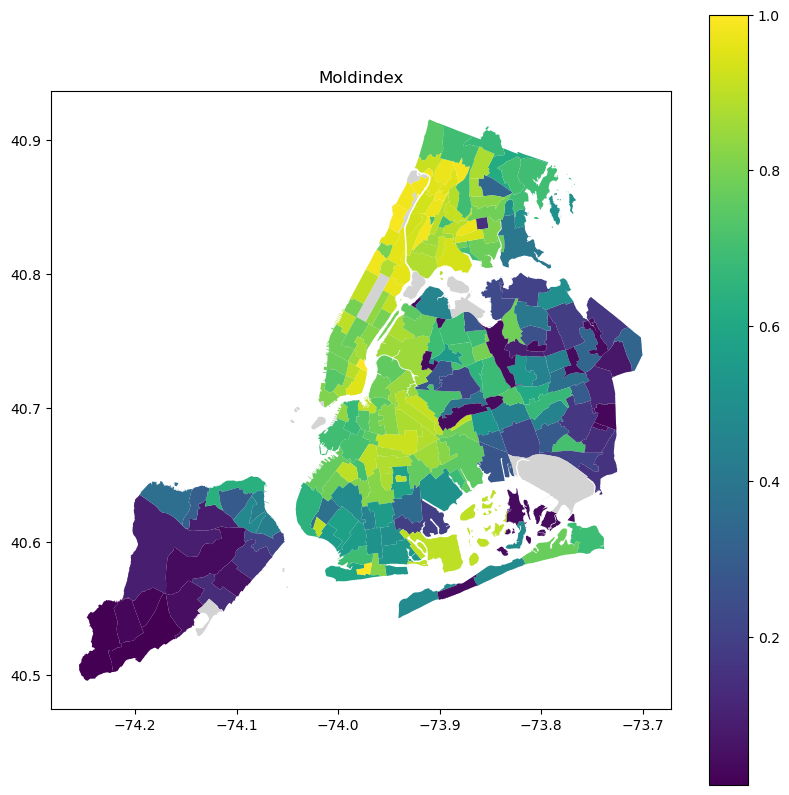

In [32]:
#Compute index
NTAResAreaMold = NTAResAreaMold[['ntacode','resarea','geometry']]
NTAResAreaMold = NTAResAreaMold.rename(columns={'resarea':'resarea_MOLD'})
NTAResAreaComb = gpd.GeoDataFrame(NTAResArea.merge(NTAResAreaMold,on='ntacode',how='left'),geometry='geometry_x')
NTAResAreaComb['Moldindex']=NTAResAreaComb['resarea_MOLD']/NTAResAreaComb['resarea']
fig, ax = plt.subplots(figsize=(10,10))
NTAResAreaComb.plot(column='Moldindex', legend=True, ax=ax,  missing_kwds= dict(color = "lightgrey",) )
ax.set_title('Moldindex')
plt.show()

In [33]:
NTAResAreaComb.head()

,ntacode,resarea,shape_area,ntaname,shape_leng,boroname,borocode,countyfips,geometry_x,resarea_MOLD,geometry_y,Moldindex
0,BK09,15473559.0,9984670.16344,Brooklyn Heights-Cobble Hill,14253.6753754,Brooklyn,3,047,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",12924694.0,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",0.835276
1,BK17,28383485.0,63343337.7196,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91064.6369183,Brooklyn,3,047,"MULTIPOLYGON (((-73.91809 40.58657, -73.91813 ...",15235434.0,"MULTIPOLYGON (((-73.91809 40.58657, -73.91813 ...",0.536771
2,BK19,14926825.0,17181121.9282,Brighton Beach,21058.8093413,Brooklyn,3,047,"MULTIPOLYGON (((-73.96035 40.58731, -73.96032 ...",12210100.0,"MULTIPOLYGON (((-73.96035 40.58731, -73.96032 ...",0.817997
3,BK21,13306658.0,38725865.5956,Seagate-Coney Island,51802.5174496,Brooklyn,3,047,"MULTIPOLYGON (((-73.97459 40.58314, -73.97459 ...",7929189.0,"MULTIPOLYGON (((-73.97459 40.58314, -73.97459 ...",0.595881
4,BK23,9724056.0,8745781.98734,West Brighton,14114.5370571,Brooklyn,3,047,"MULTIPOLYGON (((-73.96889 40.57526, -73.96895 ...",9683171.0,"MULTIPOLYGON (((-73.96889 40.57526, -73.96895 ...",0.995795


In [34]:
#Export NTA Level Moldindex values as CSV
NTAResAreaComb[['ntacode','Moldindex']].to_csv(r'../Output/Moldindex_NTA.csv')

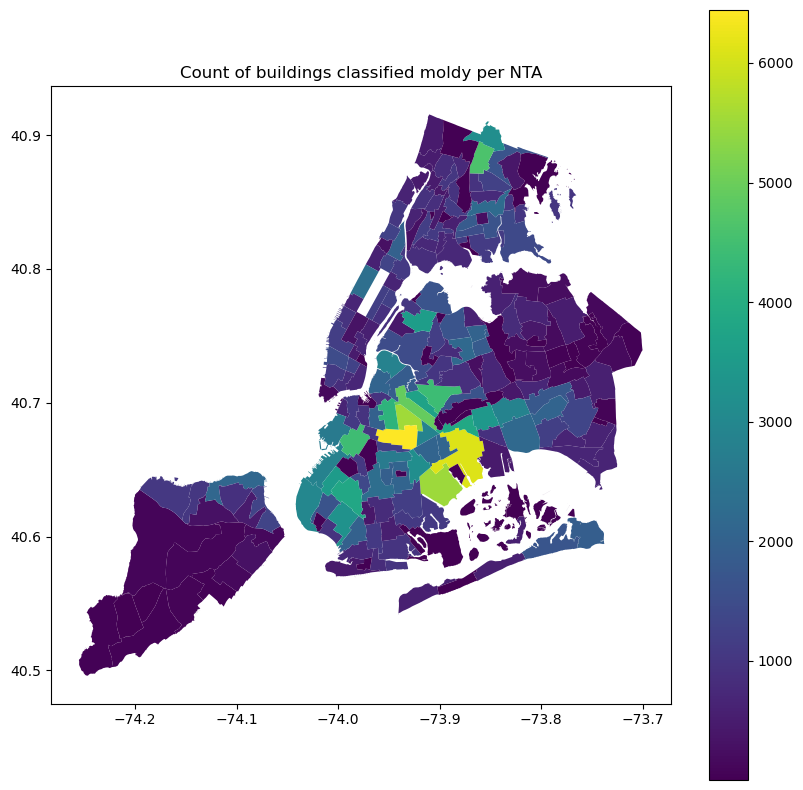

In [35]:
#Plot total Mold Counts per NTA

fig, ax = plt.subplots(figsize=(10,10))
gpd.GeoDataFrame(PlutoMoldyBldgsNTAs.groupby(by='ntacode').agg({'bbl':'count'}).merge(NTA,on='ntacode'),geometry='geometry').plot(column='bbl',legend=True,figsize=(10,10),ax=ax, missing_kwds= dict(color = "lightgrey",))
ax.set_title('Count of buildings classified moldy per NTA')
plt.show()

#


In [36]:
gpd.GeoDataFrame(PlutoMoldyBldgsNTAs.groupby(by='ntacode').agg({'bbl':'count'}).merge(NTA,on='ntacode'),geometry='geometry').sort_values('bbl')


,ntacode,bbl,shape_area,ntaname,shape_leng,boroname,borocode,countyfips,geometry
115,MN50,2,5575232.22541,Stuyvesant Town-Cooper Village,11000.1587451,Manhattan,1,061,"MULTIPOLYGON (((-73.96237 40.72421, -73.96201 ..."
172,QN99,2,311684971.61,park-cemetery-etc-Queens,490146.60402,Queens,4,081,"MULTIPOLYGON (((-73.86523 40.57046, -73.86454 ..."
189,SI48,5,50407530.0454,Arden Heights,29689.4459114,Staten Island,5,085,"MULTIPOLYGON (((-74.17185 40.56152, -74.17223 ..."
87,BX99,6,220896061.306,park-cemetery-etc-Bronx,224026.901822,Bronx,2,005,"MULTIPOLYGON (((-73.86958 40.81628, -73.86954 ..."
184,SI32,7,64959465.3375,Rossville-Woodrow,33239.3302003,Staten Island,5,085,"MULTIPOLYGON (((-74.20315 40.55606, -74.20318 ..."
...,...,...,...,...,...,...,...,...,...
38,BK78,4931,40192390.2146,Bushwick South,40778.2982055,Brooklyn,3,047,"MULTIPOLYGON (((-73.93230 40.70775, -73.93392 ..."
25,BK50,5504,82015446.67,Canarsie,43701.7910584,Brooklyn,3,047,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
15,BK35,5514,31407005.0688,Stuyvesant Heights,28239.0965854,Brooklyn,3,047,"MULTIPOLYGON (((-73.91805 40.68721, -73.91800 ..."
41,BK82,6092,117170154.658,East New York,88815.3488618,Brooklyn,3,047,"MULTIPOLYGON (((-73.86106 40.67434, -73.86107 ..."


c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


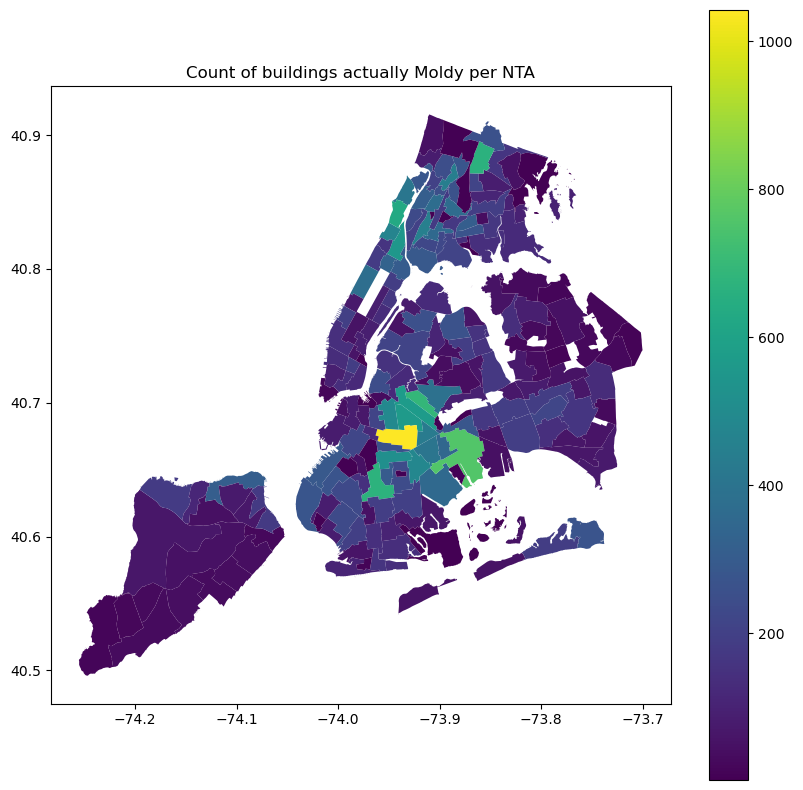

In [37]:
#Plot count of buildings with actual violations per NTA
MoldIssues=pd.read_csv(r'..\Output\bbl_mold_violation.csv')

#Merge with Pluto Geometries
ActualMoldIssuesPluto=plutoCleanedGeo.merge(MoldIssues, left_on='bbl',right_on='BBL')
# Compute NTA each point belongs to
ActualMoldIssuesPlutoNTAs = gpd.sjoin(ActualMoldIssuesPluto,NTA , op ='within')
# Summarize per NTA, count features per NTA
ActualIssuesCountperNTA = ActualMoldIssuesPlutoNTAs.groupby(by='ntacode').agg({'bbl':'count'})
#Merge Count per NTA back with NTA Geometries
NTA_ActualIssuesCount=gpd.GeoDataFrame(ActualIssuesCountperNTA.merge(NTA,on='ntacode'),geometry='geometry')


fig, ax = plt.subplots(figsize=(10,10))
NTA_ActualIssuesCount.plot(column='bbl',figsize=(10,10),legend=True,ax=ax)
ax.set_title('Count of buildings actually Moldy per NTA')
plt.show()



In [38]:
NTA_ActualIssuesCount.sort_values('bbl')

,ntacode,bbl,shape_area,ntaname,shape_leng,boroname,borocode,countyfips,geometry
115,MN50,2,5575232.22541,Stuyvesant Town-Cooper Village,11000.1587451,Manhattan,1,061,"MULTIPOLYGON (((-73.96237 40.72421, -73.96201 ..."
50,BK99,2,228790857.479,park-cemetery-etc-Brooklyn,394313.013412,Brooklyn,3,047,"MULTIPOLYGON (((-73.91513 40.58627, -73.91510 ..."
87,BX99,3,220896061.306,park-cemetery-etc-Bronx,224026.901822,Bronx,2,005,"MULTIPOLYGON (((-73.86958 40.81628, -73.86954 ..."
47,BK93,8,11598945.8236,Starrett City,17414.7816329,Brooklyn,3,047,"MULTIPOLYGON (((-73.88829 40.64672, -73.88829 ..."
4,BK23,11,8745781.98734,West Brighton,14114.5370571,Brooklyn,3,047,"MULTIPOLYGON (((-73.96889 40.57526, -73.96895 ..."
...,...,...,...,...,...,...,...,...,...
78,BX44,667,36273563.8081,Williamsbridge-Olinville,27350.9739448,Bronx,2,005,"MULTIPOLYGON (((-73.84705 40.88767, -73.84744 ..."
20,BK42,672,45254811.4745,Flatbush,38737.8527628,Brooklyn,3,047,"MULTIPOLYGON (((-73.95871 40.65039, -73.95844 ..."
37,BK77,691,25020783.0186,Bushwick North,26402.8839603,Brooklyn,3,047,"MULTIPOLYGON (((-73.90123 40.69144, -73.90180 ..."
41,BK82,758,117170154.658,East New York,88815.3488618,Brooklyn,3,047,"MULTIPOLYGON (((-73.86106 40.67434, -73.86107 ..."


### Searching for the attribute that leads to high Count of Moldy classified buildings in southeast BK

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


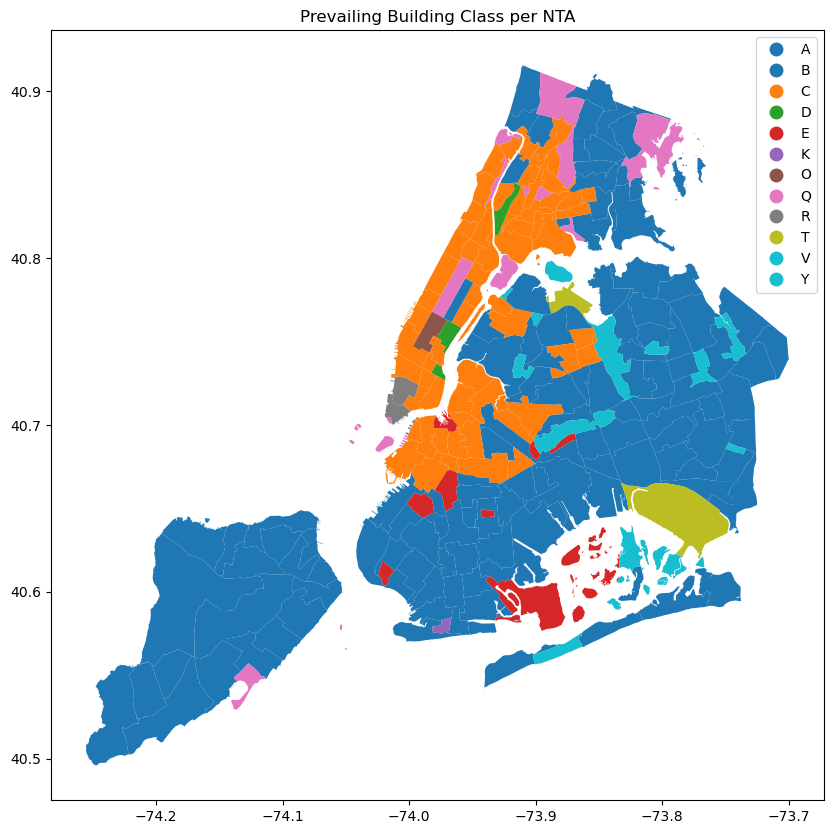

In [39]:
#Prevailing BuildingClass
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
nta_summary = pluto_ntas.groupby(['ntacode', 'main_bldg_class'])['main_bldg_class'].count().unstack(fill_value=0)
nta_summary['max_class'] = nta_summary.idxmax(axis=1)
nta_summarygeo=gpd.GeoDataFrame(nta_summary.merge(NTA,on='ntacode'),geometry='geometry')

fig, ax = plt.subplots(figsize=(10,10))
nta_summarygeo.plot(column='max_class',legend=True,figsize=(10,10),ax=ax)
ax.set_title('Prevailing Building Class per NTA')
plt.show()

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


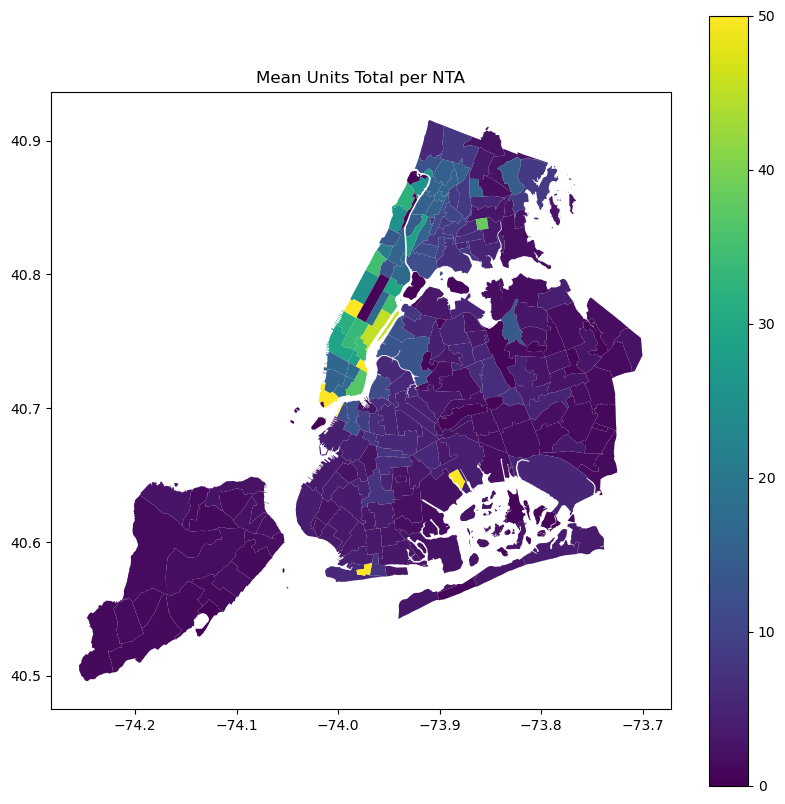

In [40]:
#Mean Unit Count
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
nta_summary = pluto_ntas.groupby(by='ntacode').agg({'unitstotal':'mean'})
nta_summarygeo=gpd.GeoDataFrame(nta_summary.merge(NTA,on='ntacode'),geometry='geometry')

fig, ax = plt.subplots(figsize=(10,10))
nta_summarygeo.plot(column='unitstotal',legend=True,figsize=(10,10),ax=ax,vmin=0,vmax=50)
ax.set_title('Mean Units Total per NTA')
plt.show()

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


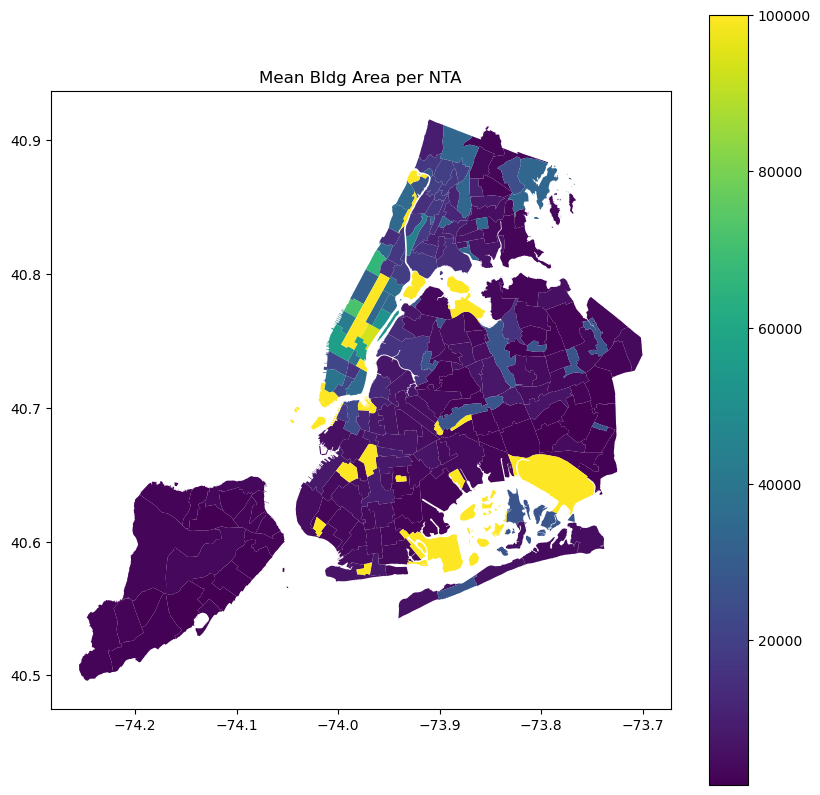

In [41]:
#mean Bldgarea

#Mean Unit Count
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
nta_summary = pluto_ntas.groupby(by='ntacode').agg({'bldgarea':'mean'})
nta_summarygeo=gpd.GeoDataFrame(nta_summary.merge(NTA,on='ntacode'),geometry='geometry')

fig, ax = plt.subplots(figsize=(10,10))
nta_summarygeo.plot(column='bldgarea',legend=True,figsize=(10,10),ax=ax,vmax=100000)
ax.set_title('Mean Bldg Area per NTA')
plt.show()


c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


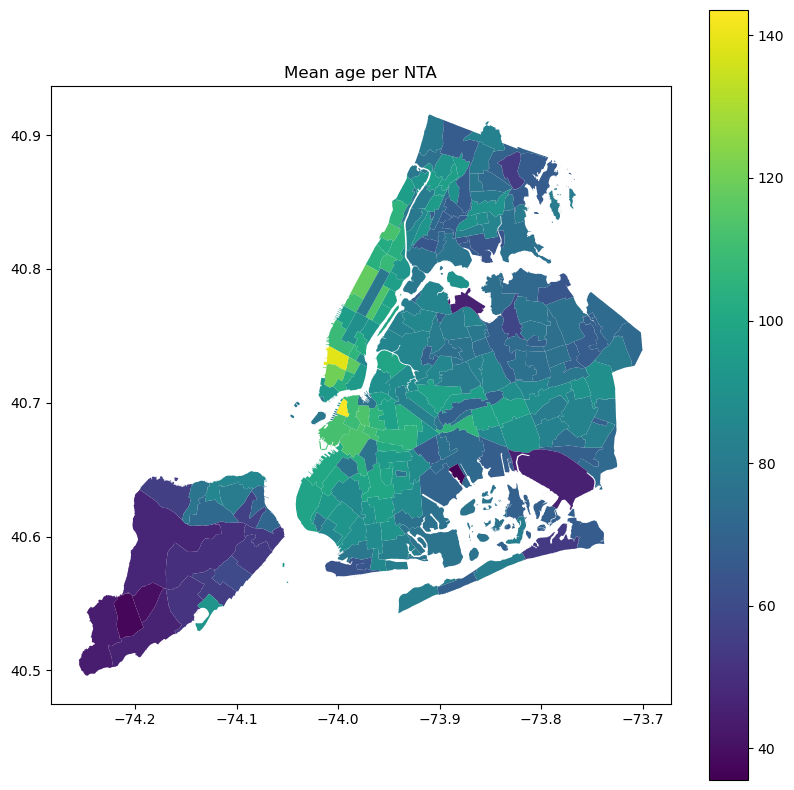

In [42]:
#mean age

#Mean Unit Count
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
nta_summary = pluto_ntas.groupby(by='ntacode').agg({'age':'mean'})
nta_summarygeo=gpd.GeoDataFrame(nta_summary.merge(NTA,on='ntacode'),geometry='geometry')

fig, ax = plt.subplots(figsize=(10,10))
nta_summarygeo.plot(column='age',legend=True,figsize=(10,10),ax=ax)
ax.set_title('Mean age per NTA')
plt.show()


c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


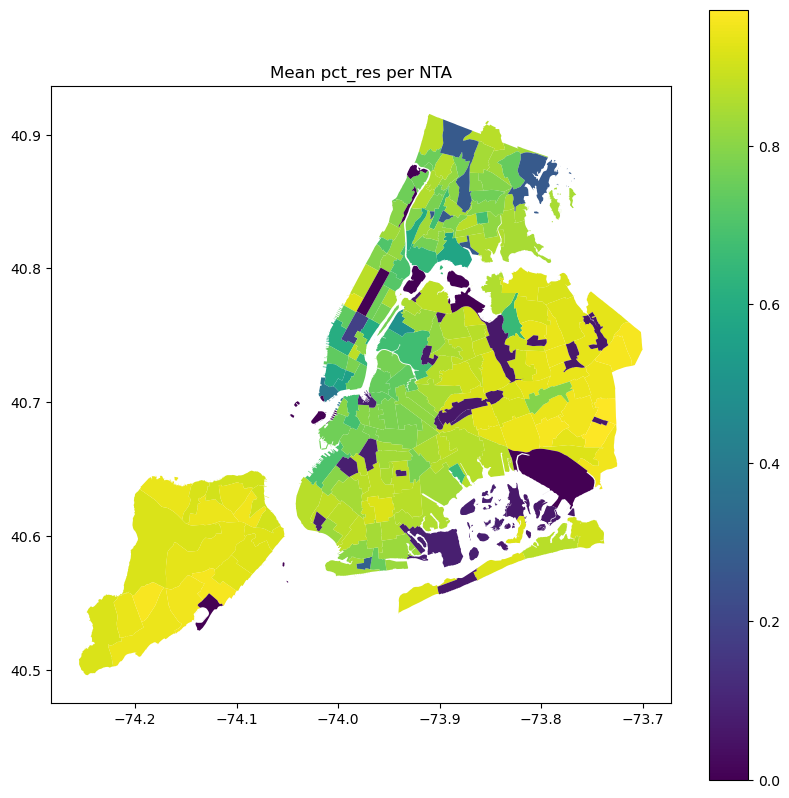

In [43]:
#mean percentage Residential

#Mean Unit Count
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
nta_summary = pluto_ntas.groupby(by='ntacode').agg({'pct_res':'mean'})
nta_summarygeo=gpd.GeoDataFrame(nta_summary.merge(NTA,on='ntacode'),geometry='geometry')

fig, ax = plt.subplots(figsize=(10,10))
nta_summarygeo.plot(column='pct_res',legend=True,figsize=(10,10),ax=ax)
ax.set_title('Mean pct_res per NTA')
plt.show()

c:\ProgramData\Miniconda3\envs\testv37\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


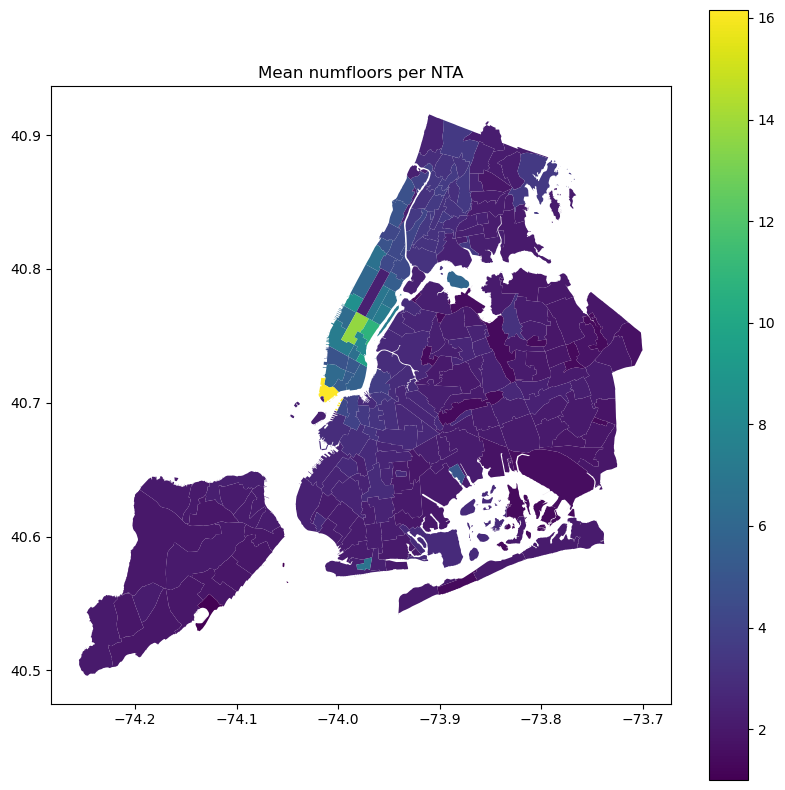

In [44]:
#mean numfloors

#Mean Unit Count
pluto_ntas = gpd.sjoin(plutoCleanedGeo,NTA, op='within')
nta_summary = pluto_ntas.groupby(by='ntacode').agg({'numfloors':'mean'})
nta_summarygeo=gpd.GeoDataFrame(nta_summary.merge(NTA,on='ntacode'),geometry='geometry')

fig, ax = plt.subplots(figsize=(10,10))
nta_summarygeo.plot(column='numfloors',legend=True,figsize=(10,10),ax=ax)
ax.set_title('Mean numfloors per NTA')
plt.show()

In [45]:
gpd.GeoDataFrame(PlutoMoldyBldgsNTAs.groupby(by='ntacode').agg({'bbl':'count'}).merge(NTA,on='ntacode'),geometry='geometry').sort_values(by='bbl')

,ntacode,bbl,shape_area,ntaname,shape_leng,boroname,borocode,countyfips,geometry
115,MN50,2,5575232.22541,Stuyvesant Town-Cooper Village,11000.1587451,Manhattan,1,061,"MULTIPOLYGON (((-73.96237 40.72421, -73.96201 ..."
172,QN99,2,311684971.61,park-cemetery-etc-Queens,490146.60402,Queens,4,081,"MULTIPOLYGON (((-73.86523 40.57046, -73.86454 ..."
189,SI48,5,50407530.0454,Arden Heights,29689.4459114,Staten Island,5,085,"MULTIPOLYGON (((-74.17185 40.56152, -74.17223 ..."
87,BX99,6,220896061.306,park-cemetery-etc-Bronx,224026.901822,Bronx,2,005,"MULTIPOLYGON (((-73.86958 40.81628, -73.86954 ..."
184,SI32,7,64959465.3375,Rossville-Woodrow,33239.3302003,Staten Island,5,085,"MULTIPOLYGON (((-74.20315 40.55606, -74.20318 ..."
...,...,...,...,...,...,...,...,...,...
38,BK78,4931,40192390.2146,Bushwick South,40778.2982055,Brooklyn,3,047,"MULTIPOLYGON (((-73.93230 40.70775, -73.93392 ..."
25,BK50,5504,82015446.67,Canarsie,43701.7910584,Brooklyn,3,047,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
15,BK35,5514,31407005.0688,Stuyvesant Heights,28239.0965854,Brooklyn,3,047,"MULTIPOLYGON (((-73.91805 40.68721, -73.91800 ..."
41,BK82,6092,117170154.658,East New York,88815.3488618,Brooklyn,3,047,"MULTIPOLYGON (((-73.86106 40.67434, -73.86107 ..."


In [ ]:
#Scatter plot between the hortspot of actual vs classified highest NTA - x = highest counmt actual Values of NTA y 